# アルピコホールディングス 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '297A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='max')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00+09:00,261.0,265.0,260.0,261.0,147100,0.0,0.0
2025-03-21 00:00:00+09:00,258.0,260.0,256.0,256.0,282000,0.0,0.0
2025-03-24 00:00:00+09:00,250.0,257.0,250.0,250.0,748900,0.0,0.0
2025-03-25 00:00:00+09:00,253.0,254.0,250.0,254.0,272900,0.0,0.0
2025-03-26 00:00:00+09:00,252.0,260.0,250.0,260.0,320800,0.0,0.0


## 日足チャートとパラボリック SAR

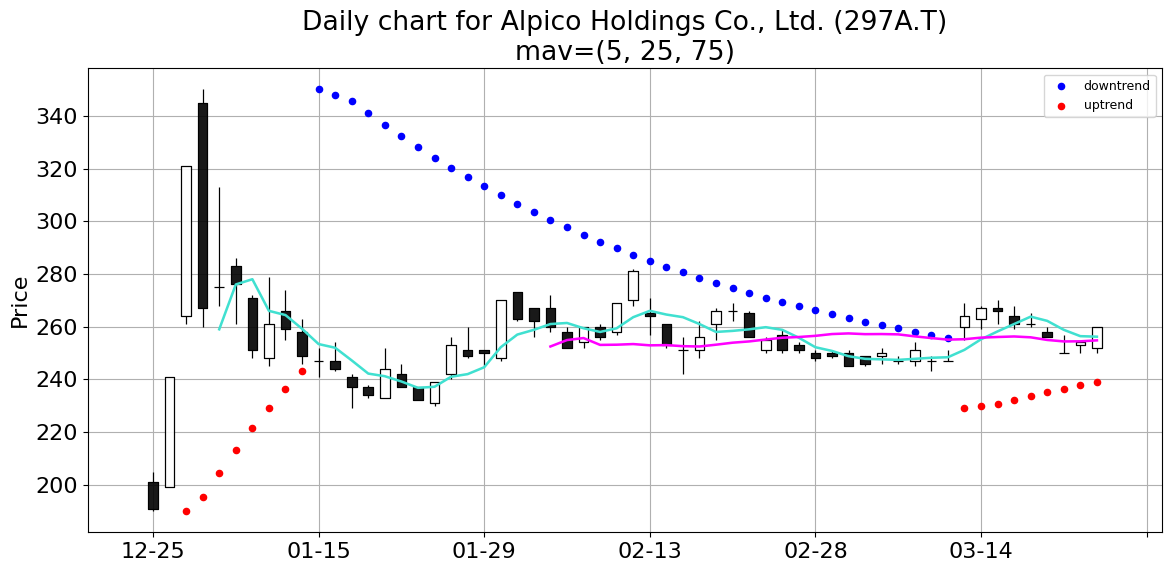

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-25 00:00:00+09:00    254.0
2025-03-26 00:00:00+09:00    260.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-25 00:00:00+09:00    NaN
2025-03-26 00:00:00+09:00    6.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-25 00:00:00+09:00    256.4
2025-03-26 00:00:00+09:00    256.2
Name: Close, dtype: float64